In [1]:
import sqlite3 as db
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#making conn

conn = db.connect("olist.db")
df_tables = pd.read_sql_query (
"""
SELECT name FROM sqlite_master WHERE type = 'table';
"""
,conn)
df_tables

,name
0,olist_order_customer_dataset
1,olist_order_dataset
2,olist_order_reviews_dataset
3,olist_order_payments_dataset
4,olist_order_items_dataset
5,olist_products_dataset
6,olist_sellers_dataset
7,olist_geolocation_dataset
8,product_category_name_translation


In [17]:
#assigning each table to variable

order_customer = pd.read_sql_query("""SELECT * FROM olist_order_customer_dataset;""", conn)
order = pd.read_sql_query("""SELECT * FROM olist_order_dataset;""", conn)
order_reviews = pd.read_sql_query("""SELECT * FROM olist_order_reviews_dataset;""", conn)
order_payments = pd.read_sql_query("""SELECT * FROM olist_order_payments_dataset;""", conn)
order_items = pd.read_sql_query("""SELECT * FROM olist_order_items_dataset;""", conn)
products = pd.read_sql_query("""SELECT * FROM olist_products_dataset;""", conn)
sellers = pd.read_sql_query("""SELECT * FROM olist_sellers_dataset;""", conn)
geolocation = pd.read_sql_query("""SELECT * FROM olist_geolocation_dataset;""", conn)
product_category_name_translation = pd.read_sql_query("""SELECT * FROM product_category_name_translation;""", conn)

In [4]:
#checking null in data

null_table = pd.DataFrame()
null_item = [order_customer, order, order_reviews, order_payments, order_items, products, sellers, geolocation]
column_name = ["order_customer", "order", "order_reviews", "order_payments", "order_items","products", "sellers", "geolocation"]
for item in null_item:
    null_table = pd.concat([null_table, item.isnull().sum()], ignore_index=True, axis = 1)
null_table.columns = column_name
null_table.replace(0, None).dropna(how="all").fillna(0)

,order_customer,order,order_reviews,order_payments,order_items,products,sellers,geolocation
order_approved_at,0,160.0,0.0,0,0,0.0,0,0
order_delivered_carrier_date,0,1783.0,0.0,0,0,0.0,0,0
order_delivered_customer_date,0,2965.0,0.0,0,0,0.0,0,0
review_comment_title,0,0.0,87656.0,0,0,0.0,0,0
review_comment_message,0,0.0,58247.0,0,0,0.0,0,0
product_category_name,0,0.0,0.0,0,0,610.0,0,0
product_name_lenght,0,0.0,0.0,0,0,610.0,0,0
product_description_lenght,0,0.0,0.0,0,0,610.0,0,0
product_photos_qty,0,0.0,0.0,0,0,610.0,0,0
product_weight_g,0,0.0,0.0,0,0,2.0,0,0


In [5]:
order_canceled = pd.read_sql_query(
    """SELECT order_status, 
    SUM(CASE WHEN order_approved_at is NULL THEN 1 ELSE 0 END) as null_approved,
    SUM(CASE WHEN order_delivered_carrier_date is NULL THEN 1 ELSE 0 END) as null_deliv_carrier,
    SUM(CASE WHEN order_delivered_customer_date is NULL THEN 1 ELSE 0 END) as null_deliv_cust
    FROM olist_order_dataset
    GROUP BY order_status;"""
,conn)
order_canceled

,order_status,null_approved,null_deliv_carrier,null_deliv_cust
0,approved,0,2,2
1,canceled,141,550,619
2,created,5,5,5
3,delivered,14,2,8
4,invoiced,0,314,314
5,processing,0,301,301
6,shipped,0,0,1107
7,unavailable,0,609,609


In [6]:
order.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
cursor = conn.cursor()

cursor.execute ("""
CREATE TEMPORARY TABLE cleaned_olist_order_dataset AS
SELECT  order_id,
        customer_id,
        order_status,
        order_purchase_timestamp,
        COALESCE(order_approved_at, "9999-01-01") as order_approved_at,
        COALESCE(order_delivered_carrier_date, "9999-01-01") as order_delivered_carrier_date,
        COALESCE(order_delivered_customer_date, "9999-01-01") as order_delivered_customer_date,
        order_estimated_delivery_date
FROM olist_order_dataset;
""")

cursor.execute("""
DROP TABLE olist_order_dataset;
""")

cursor.execute("""
ALTER TABLE cleaned_olist_order_dataset RENAME TO olist_order_dataset;
""")

conn.commit()

In [8]:
cursor.execute ("""
CREATE TEMPORARY TABLE cleaned_olist_order_reviews_dataset AS
SELECT  review_id,
        order_id,
        review_score,
        COALESCE(review_comment_title, "no review") as review_comment_title,
        COALESCE(review_comment_message, "no review") as review_comment_message,
        review_creation_date,
        review_answer_timestamp
FROM olist_order_reviews_dataset;
""")

cursor.execute("""
DROP TABLE olist_order_reviews_dataset;
""")

cursor.execute("""
ALTER TABLE cleaned_olist_order_reviews_dataset RENAME TO olist_order_reviews_dataset;
""")

conn.commit()

In [12]:
products.head()

,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [11]:
products["product_name_lenght"].mode()

0    60.0
Name: product_name_lenght, dtype: float64

In [13]:
products["product_description_lenght"].mode()

0    404.0
Name: product_description_lenght, dtype: float64

In [15]:
products["product_photos_qty"].mode()

0    1.0
Name: product_photos_qty, dtype: float64

In [16]:
cursor.execute ("""
CREATE TEMPORARY TABLE cleaned_olist_products_dataset AS
SELECT  product_id,
        COALESCE(product_category_name, "unknown") as product_category_name,
        COALESCE(product_name_lenght, 60) as product_name_length,
        COALESCE(product_description_lenght, 404) as product_description_length,
        COALESCE(product_photos_qty, 1) as product_photos_qty,
        product_weight_g,
        product_length_cm,
        product_height_cm,
        product_width_cm

FROM olist_products_dataset
WHERE product_weight_g IS NOT NULL;
""")

cursor.execute("""
DROP TABLE olist_products_dataset;
""")

cursor.execute("""
ALTER TABLE cleaned_olist_products_dataset RENAME TO olist_products_dataset;
""")

conn.commit()

In [18]:
null_table = pd.DataFrame()
null_item = [order_customer, order, order_reviews, order_payments, order_items, products, sellers, geolocation]
column_name = ["order_customer", "order", "order_reviews", "order_payments", "order_items","products", "sellers", "geolocation"]
for item in null_item:
    null_table = pd.concat([null_table, item.isnull().sum()], ignore_index=True, axis = 1)
null_table.columns = column_name
null_table.replace(0, None).dropna(how="all").fillna(0)

,order_customer,order,order_reviews,order_payments,order_items,products,sellers,geolocation


In [19]:
#cheking duplicate in data

duplicated_table = pd.DataFrame()
duplicated_item = [order_customer, order, order_reviews, order_payments, order_items, products, sellers, geolocation]
column_name = ["order_customer", "order", "order_reviews", "order_payments", "order_items","products", "sellers", "geolocation"]

for item in duplicated_item:
    duplicated_table = pd.concat([duplicated_table, item.duplicated()], ignore_index=True, axis = 1)
duplicated_table.columns = column_name
duplicated_table.any()

order_customer    False
order             False
order_reviews     False
order_payments    False
order_items       False
products          False
sellers           False
geolocation       False
dtype: bool

In [12]:
order

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [10]:
product_id_check = pd.read_sql_query(
    """SELECT *
    FROM olist_order_items_dataset
    WHERE product_id IN (SELECT product_id FROM olist_products_dataset WHERE product_category_name is NULL)
    ORDER BY shipping_limit_date asc;"""
,conn)
product_id_check

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,4451,0a0837a5eee9e7a9ce2b1fa831944d27,1,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2016-10-10 11:43:22,49.99,15.51
1,79667,b533dea24ada4dc5c1a9041d25d7c812,1,661e3bba6bdb874638367462b49ae590,23613d49c3ac2bd302259e55c06c050c,2016-10-15 04:56:41,15.90,14.52
2,84557,c022b7da8ab7a4a04bd561c8f765a14a,1,d36c8237f8a0a889aa9d6ac7816097e3,80e6699fe29150b372a0c8a1ebf7dcc8,2017-01-21 23:40:42,169.00,25.00
3,43119,6219ece1f053a3ffa649340e87cd93d2,1,aa2b29bee083c3eb3779f39fc09527b7,46dc3b2cc0980fb8ec44634e21d2718e,2017-01-24 15:08:05,349.99,20.69
4,15040,22474d84064cd7eb4a907ba3fd8a6398,1,6f6f3b1a96452e2fbad0cd4f7082765b,ff314fa6033cc68ec451c47aee2d6ba4,2017-01-29 09:09:46,279.90,16.88
...,...,...,...,...,...,...,...,...
1598,68337,9c33774fba00c73b651903f988c71bb9,1,f524a09994004b2dabb3d13cf1a041fb,0c8380b62e38e8a1e6adbeba7eb9688c,2018-08-27 12:30:50,249.90,42.73
1599,101050,e53249d8b27242c64053f94e2af2b2ba,1,b0645512783cc56c9510f08e90a40ede,8648b1e89e9b349e32d3741b30ec737e,2018-08-29 21:35:11,59.90,7.68
1600,44897,6616fa4c89b8bf2a7e17271cdc542fca,2,fc5dd987f12a7b823a76a44aa1ba88f6,49067458c68f7701fd334ce326accbe0,2018-08-30 03:09:38,28.45,6.66
1601,101767,e6f6345c50327507fe35965aa65c8e94,1,fd85f34d70edf41fbea6a3269d183e00,caa9bc43a9fe8cf9c564ddd8a03cc4a6,2018-08-30 19:05:19,29.99,7.47


In [ ]:
#BEST AND WORST SELLING CATEGORY

In [26]:
num_order_per_category = pd.read_sql_query(
    """
    SELECT product_category_name_english as category_name, COUNT(o.order_id) as num_of_order FROM olist_products_dataset p
    JOIN olist_order_items_dataset oi
    ON p.product_id = oi.product_id
    JOIN olist_order_dataset o
    ON oi.order_id = o.order_id
    JOIN product_category_name_translation pcn
    ON p.product_category_name = pcn.product_category_name
    GROUP BY 1
    ORDER BY 2 DESC
    """
, conn)
num_order_per_category[-10:]

,category_name,num_of_order
61,music,38
62,furniture_mattress_and_upholstery,38
63,flowers,33
64,home_comfort_2,30
65,fashion_sport,30
66,arts_and_craftmanship,24
67,la_cuisine,14
68,cds_dvds_musicals,14
69,fashion_childrens_clothes,8
70,security_and_services,2


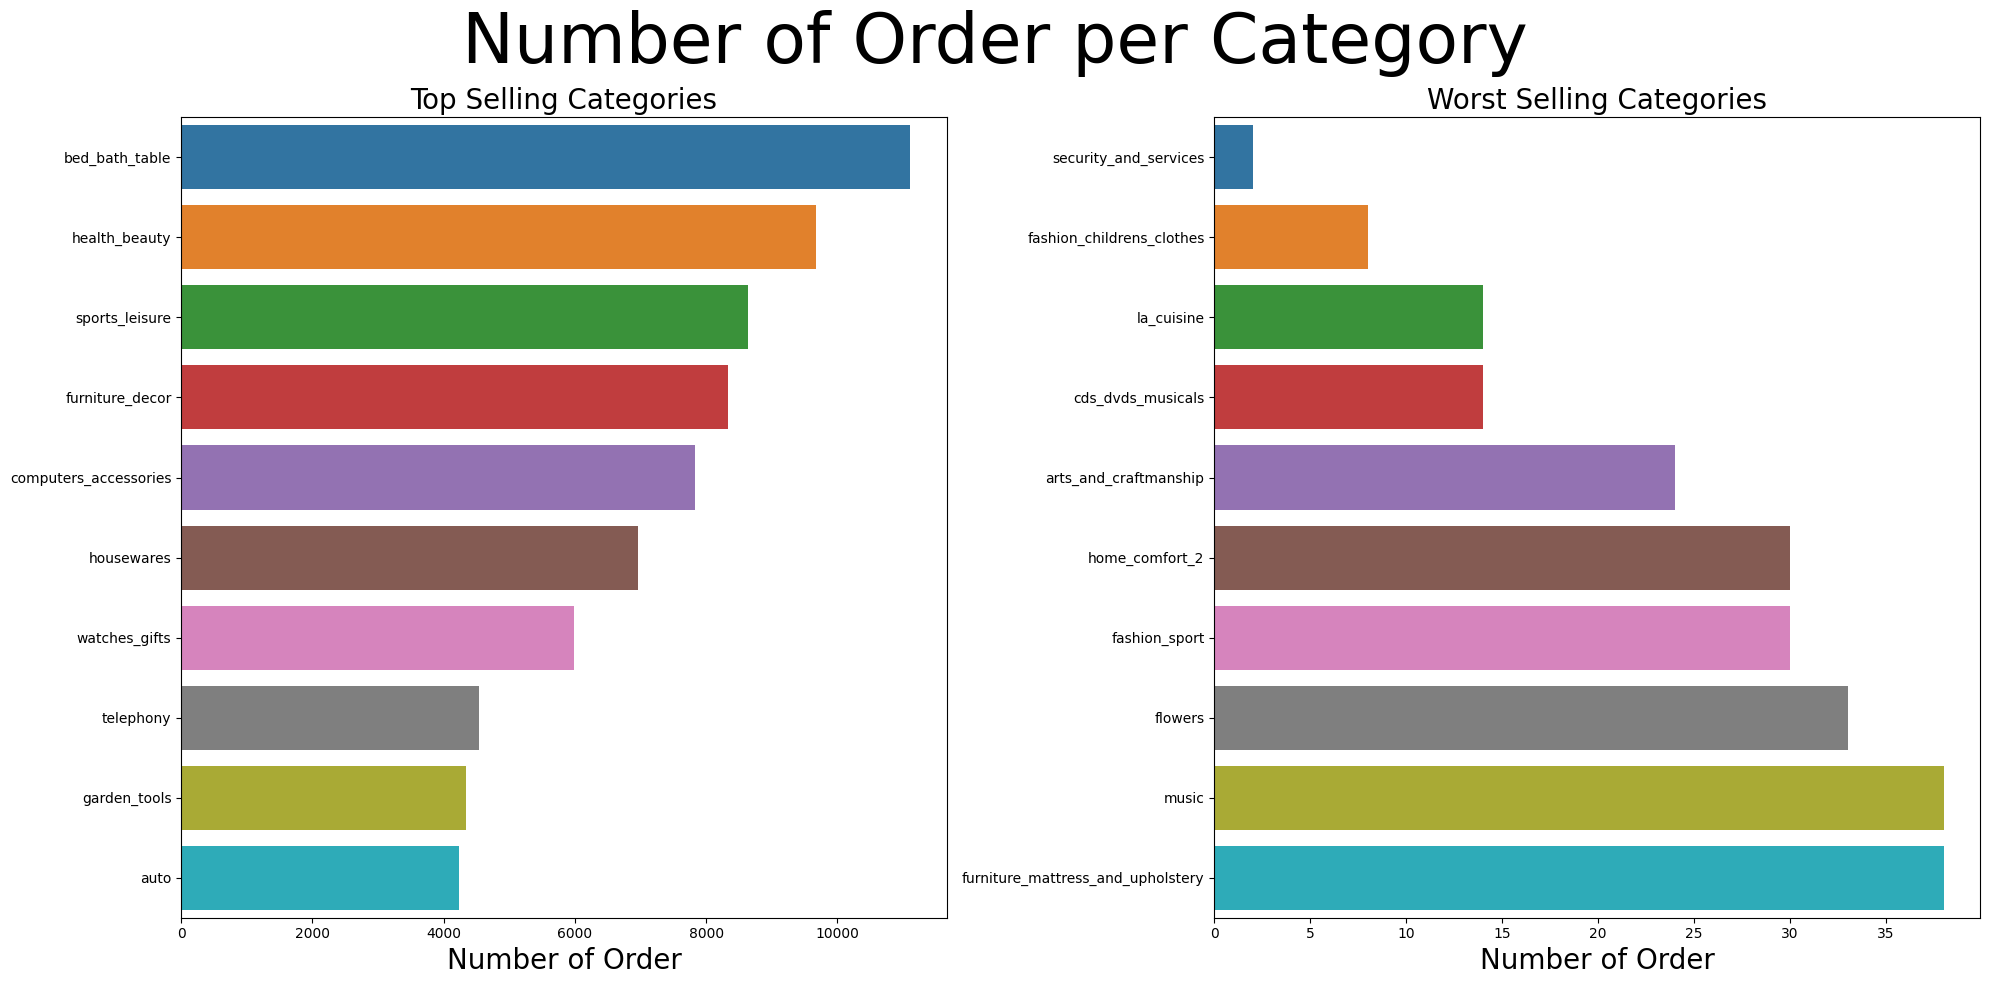

In [27]:
top_category = num_order_per_category[:10]
bottom_category = num_order_per_category[-10:].sort_values(by="num_of_order")


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10)) #gridspec_kw={'width_ratios': [2, 1]})

sns.barplot(data = top_category, x="num_of_order", y="category_name", orient = "h", ax = ax[0])
ax[0].set_title("Top Selling Categories", fontsize = 20)
ax[0].set_xlabel("Number of Order", fontsize = 20)
ax[0].set_ylabel("")

sns.barplot(data = bottom_category, x="num_of_order", y="category_name", orient = "h", ax = ax[1])
ax[1].set_title("Worst Selling Categories", fontsize = 20)
ax[1].set_xlabel("Number of Order", fontsize = 20)
ax[1].set_ylabel("")

plt.suptitle("Number of Order per Category", fontsize = 50)
plt.tight_layout()
plt.show()




In [31]:
order_items.dtypes

index                    int64
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

<AxesSubplot: >

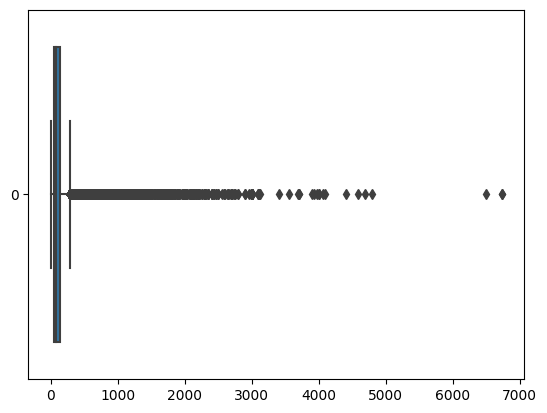

In [13]:
sns.boxplot(data = order_items["price"], orient = "h")

In [22]:
q1 = order_items["price"].quantile(0.25)
q3 = order_items["price"].quantile(0.75)

IQR = q3-q1
max_value = q3+1.5*IQR

#order_items.loc[order_items["price"]>max_value]
order_items_cleaned = order_items.loc[order_items["price"]<max_value]
order_items_cleaned

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...,...
112643,112643,fffb9224b6fc7c43ebb0904318b10b5f,4,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112644,112644,fffbee3b5462987e66fb49b1c5411df2,1,6f0169f259bb0ff432bfff7d829b9946,213b25e6f54661939f11710a6fddb871,2018-06-28 09:58:03,119.85,20.03
112647,112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


<AxesSubplot: >

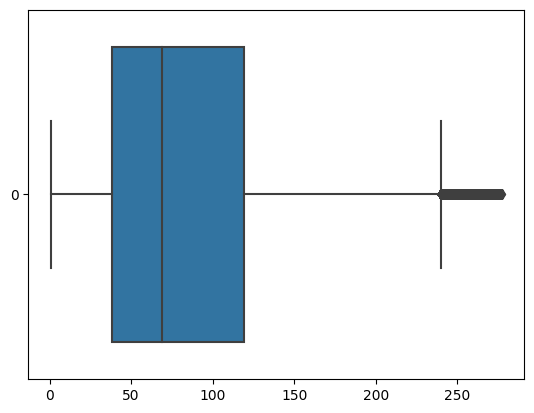

In [25]:
sns.boxplot(data = order_items_cleaned["price"], orient = "h")

In [27]:
order_items_cleaned["price"].describe()

count    104223.000000
mean         83.974668
std          58.580002
min           0.850000
25%          38.500000
50%          69.000000
75%         118.990000
max         277.300000
Name: price, dtype: float64

In [83]:

# Define the intervals
bins = [x for x in range(0,300,20)]
label = [f"{x} to {x+20}" for x in range(0,280,20)]

# Create a new column for the interval labels
order_items_cleaned['price_interval'] = pd.cut(order_items_cleaned["price"], bins, labels = label)

# Count the number of orders in each interval
interval_counts = order_items_cleaned['price_interval'].value_counts().reset_index()

# Print the result
print(interval_counts)


         index  price_interval
0     20 to 40           20165
1     40 to 60           19152
2     60 to 80           12163
3    80 to 100           11456
4      0 to 20            9401
5   100 to 120            8176
6   120 to 140            6217
7   140 to 160            5440
8   160 to 180            3768
9   180 to 200            3338
10  200 to 220            1635
11  220 to 240            1388
12  240 to 260            1349
13  260 to 280             575


C:\Users\Eko Yuswanto\AppData\Local\Temp\ipykernel_26748\3937602494.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_items_cleaned['price_interval'] = pd.cut(order_items_cleaned["price"], bins, labels = label)


<AxesSubplot: ylabel='price_interval'>

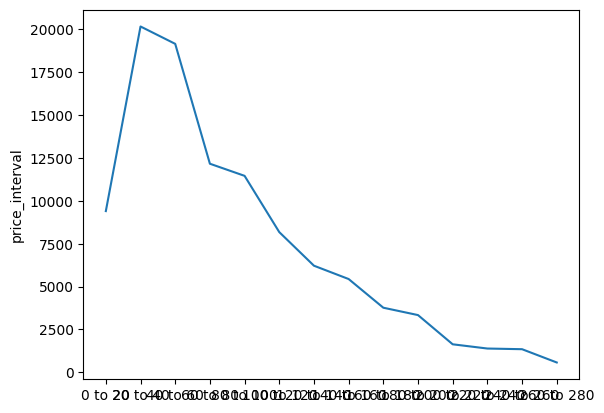

In [58]:
sns.lineplot(interval_counts)